# Project Setup: Grover's Algorithm

Useful resources and links:
- (Theory) But what is Quantum Computing?, by 3blue1brown
  - (sounds vague but it talks about Grover's algorithm in depth)
  - https://www.youtube.com/watch?v=RQWpF2Gb-gU
  - https://www.youtube.com/watch?v=Dlsa9EBKDGI (follow-up clarification)
- (Theory) Comparing Grover's algorithm to linear search when finding multiple queried elements, by Alexander Skalski and David Aldenbro
  - https://www.diva-portal.org/smash/get/diva2:1886690/FULLTEXT01.pdf
- (Theory) Lesson on Grover's Algorithm, by Qiskit
  - https://www.youtube.com/watch?v=hnpjC8WQVrQ
- (Theory/Implementation) Grover's Algorithm, by CNOT.io
  - https://cnot.io/quantum_algorithms/grover/grovers_algorithm.html
  - (at the very end of the page (before 'Next Section'), there's a link to a sample circuit for a 4-qubit QPU)

In [ ]:
# Dump all pip packages here

!pip install "qiskit[all]~=2.1" "qiskit-ibm-runtime~=0.41"

!pip install -U qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.7/368.7 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.1/29.1 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.5/541.5 kB 33.2 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexen

In [ ]:
# Python imports

import math
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendSamplerV2
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [ ]:
# Representing a QPU state in circle notation
# (code taken from lab assignment resources)

def sv_from_circ(circ: QuantumCircuit) -> np.ndarray:
    sv = Statevector(circ)
    return np.asarray(sv, dtype=np.complex128)

class QubitSystem:
    def __init__(self, statevector: np.ndarray, label: str = "Qubit System"):
        self.label = label
        self.set_statevector(statevector)

    def set_statevector(self, statevector: np.ndarray):
        sv = np.asarray(statevector, dtype=np.complex128).flatten()
        if sv.ndim != 1:
            raise ValueError("Statevector must be 1D.")
        n_states = sv.size
        n_qubits = int(round(math.log2(n_states)))
        if 2**n_qubits != n_states:
            raise ValueError("Length must be a power of 2.")
        # Defensive normalization (harmless if already normalized)
        norm = np.linalg.norm(sv)
        if norm != 0 and not np.isclose(norm, 1.0):
            sv = sv / norm

        self.n_qubits = n_qubits
        self.n_states = n_states
        self.amps  = sv
        self.prob  = np.abs(sv)**2
        self.phase = np.angle(sv)

    def viz_circle(self, max_cols: int = 8, figsize_scale: float = 2.3):
        cols = max(1, min(max_cols, self.n_states))
        rows = int(math.ceil(self.n_states / cols))

        fig, axes = plt.subplots(
            rows, cols,
            figsize=(cols*figsize_scale, rows*(figsize_scale+0.2))
        )
        axes = np.atleast_2d(axes)

        def bitstr(i: int, n: int) -> str:
            return format(i, f"0{n}b")

        for idx in range(rows * cols):
            r, c = divmod(idx, cols)
            ax = axes[r, c]
            ax.set_aspect("equal")
            ax.set_xlim(0, 1); ax.set_ylim(0, 1)
            ax.axis("off")

            if idx >= self.n_states:
                ax.set_visible(False)
                continue

            # Outer reference circle
            ax.add_patch(plt.Circle((0.5, 0.5), 0.48, fill=False, lw=1.0, alpha=0.5))

            # Filled disk: radius ∝ sqrt(probability) so area ∝ probability
            radius = 0.48 * np.sqrt(self.prob[idx])
            ax.add_patch(plt.Circle((0.5, 0.5), radius, alpha=0.25))

            # Phase arrow
            angle = self.phase[idx]
            L = 0.45
            x2 = 0.5 + L * np.cos(angle)
            y2 = 0.5 + L * np.sin(angle)
            ax.arrow(0.5, 0.5, x2 - 0.5, y2 - 0.5,
                     head_width=0.03, head_length=0.05, length_includes_head=True)

            ax.set_title(f"|{bitstr(idx, self.n_qubits)}⟩", fontsize=10)

        fig.suptitle(self.label, fontsize=12)
        plt.tight_layout()
        plt.show()

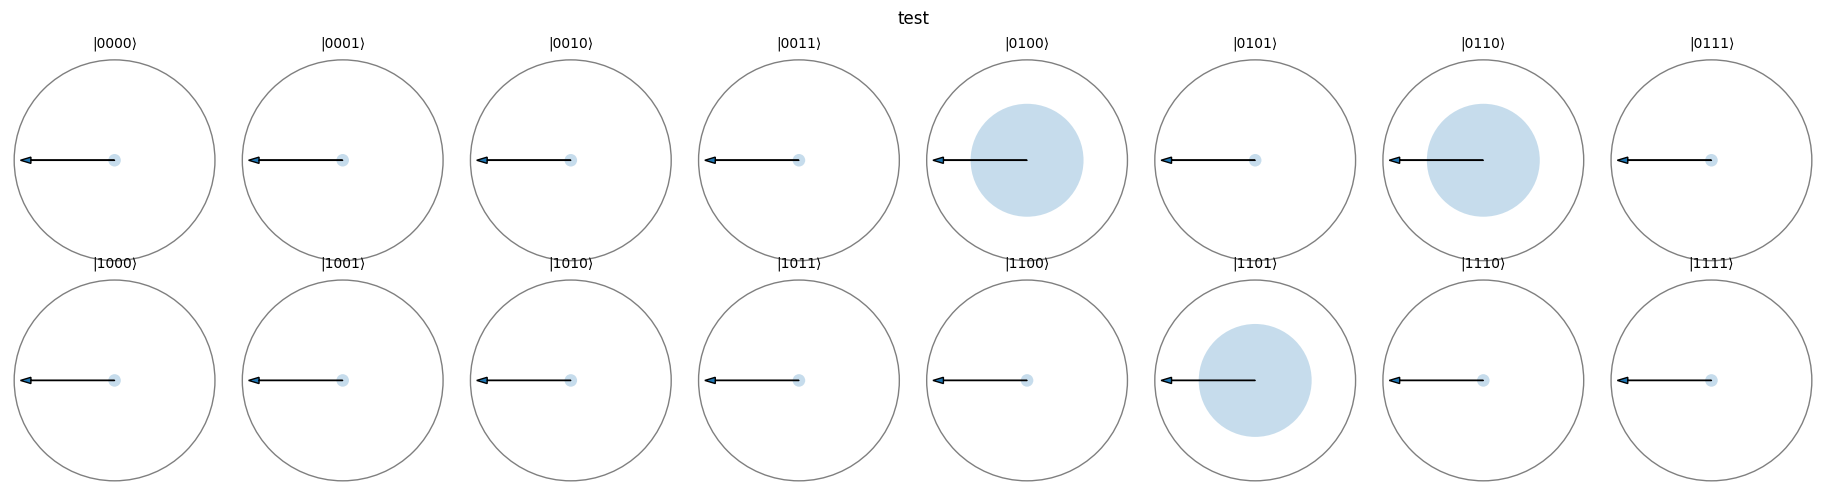

In [ ]:
n = 4     # no. of qubits
m = 1     # no. of expected solutions (unused)

# Auxiliary stuff

#C?Z gate from H + C?NOT gates
cNz = QuantumCircuit(n)
cNz.h(n-1)
cNz.mcx(list(range(n - 1)), n - 1)
cNz.h(n-1)

def gen_oracle(target_states):
  new_oracle = QuantumCircuit(n)

  for target_state in target_states:

    for i, bit in enumerate(target_state):
      if bit == '0':
        new_oracle.x(i)   # add X gates on qubits where target index is 0

    new_oracle.compose(cNz, qubits=list(range(n)), inplace=True)

    for i, bit in enumerate(target_state):
      if bit == '0':
        new_oracle.x(i)   # undo first step

  return new_oracle

# Oracle blocks
oracle_1 = QuantumCircuit(n)    # 1 target (|15>)
oracle_1.compose(cNz, qubits=list(range(n)), inplace=True)  # 1 target

oracle_2 = gen_oracle(['0110', '1011'])                     # 2 targets

oracle_3 = gen_oracle(['0110', '1011', '0010'])             # 3 targets

oracle_4 = gen_oracle(['0110', '1011', '0010', '1100'])     # 4 targets

# Diffuser/mirror block
diffuser = QuantumCircuit(n)

for i in range(n):
  diffuser.h(i)
  diffuser.x(i)

diffuser.compose(cNz, qubits=range(n), inplace=True)

for i in range(n):
  diffuser.x(i)
  diffuser.h(i)


# Main circuits
def gen_circuit(targets, iterations):
  qc = QuantumCircuit(n)

  for i in range(n):
    qc.h(i)               # Init block

  #iterations = math.floor((math.pi/4) * math.sqrt(n/m))
  if targets == 1:
    oracle = oracle_1
  if targets == 2:
    oracle = oracle_2
  if targets == 3:
    oracle = oracle_3
  if targets == 4:
    oracle = oracle_4

  for j in range(iterations):
    qc.append(oracle.to_instruction(), range(n))
    qc.append(diffuser.to_instruction(), range(n))


  return qc

qc_1targets_1iter = gen_circuit(1, 1)
qc_1targets_2iter = gen_circuit(1, 2)
qc_1targets_3iter = gen_circuit(1, 3)
qc_1targets_4iter = gen_circuit(1, 4)
qc_1targets_5iter = gen_circuit(1, 5)

qc_2targets_1iter = gen_circuit(2, 1)
qc_2targets_2iter = gen_circuit(2, 2)
qc_2targets_3iter = gen_circuit(2, 3)
qc_2targets_4iter = gen_circuit(2, 4)
qc_2targets_5iter = gen_circuit(2, 5)

qc_3targets_1iter = gen_circuit(3, 1)
qc_3targets_2iter = gen_circuit(3, 2)
qc_3targets_3iter = gen_circuit(3, 3)
qc_3targets_4iter = gen_circuit(3, 4)
qc_3targets_5iter = gen_circuit(3, 5)

qc_4targets_1iter = gen_circuit(4, 1)
qc_4targets_2iter = gen_circuit(4, 2)
qc_4targets_3iter = gen_circuit(4, 3)
qc_4targets_4iter = gen_circuit(4, 4)
qc_4targets_5iter = gen_circuit(4, 5)

qc = qc_3targets_1iter    # To test the simulator with different circuits, change this line
QubitSystem(sv_from_circ(qc), label="test").viz_circle()



# Simulator

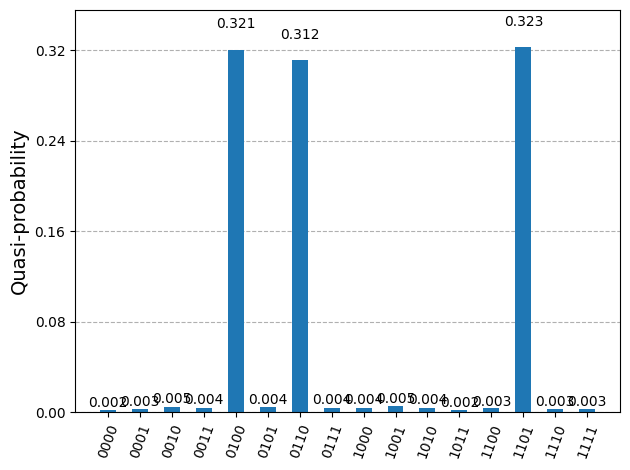

In [ ]:
qc.measure_all()

shots = 4000
counts = AerSimulator().run(transpile(qc, AerSimulator()), shots=shots).result().get_counts()
probs = {state: count / shots for state, count in counts.items()}
plot_histogram(probs)

Multiple target results for the simulator
| Targets | After 1 iter. | After 2 iter. | After 3 iter. | After 4 iter. | After 5. iter |
| ------- | ------------- | ------------- | ------------- | ------------- | ------------- |
| 1 | 0.47 | 0.898 | **0.958** | 0.578 | 0.125 |
| 2 | 0.786 | **0.947** | 0.332 | 0.011 | 0.547 |
| 3 | **0.954** | 0.611 | 0.000 | 0.596 | 0.959 |
| 4 | **1** | 0.254 | 0.243 | 1 | 0.252 |


Observations:
- for lower values of m (target count), after a suboptimal number of iterations, it is noticeably more rare for a correct solution to be read;
- for higher values of m (target count), after a suboptimal number of iterations, all outcomes appear (nearly) equally likely;
- for all values of m (target count), there appears to be a sinusoidal trend where, after a certain number of iterations away from the optimal value, we will find an iteration count that provides an equally better if not slightly better outcome distribution (e.g.: for targets=3, the outcome for iterations=5 is *slightly* better than that of iterations=1, but for practical reasons, we consider iterations=1 to be the optimal value)


# Hardware

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# >>> Edit these two lines:
TOKEN = "for obvious reasons we'll omit this part"   # REQUIRED
INSTANCE = None  # OPTIONAL: e.g., "crn:v1:bluemix:public:quantum-computing:us-east:...:..."

# Safety check to avoid empty tokens
if not TOKEN or TOKEN.strip() in {"", "<PASTE-YOUR-IBM-QUANTUM-API-KEY-HERE>"}:
    raise ValueError("Please paste your IBM Quantum API key into TOKEN (between quotes) and run again.")

# Create the service directly (no saved account needed)
service = QiskitRuntimeService(
    channel="ibm_quantum_platform",
    token=TOKEN.strip(),
    instance=(INSTANCE.strip() if isinstance(INSTANCE, str) and INSTANCE.strip() else None),
)

# Quick sanity check
backends = service.backends(operational=True, simulator=False)
print("OK. Found", len(backends), "real backends. Example:", [b.name for b in backends[:3]])

QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=TOKEN.strip(),
    instance=(INSTANCE.strip() if isinstance(INSTANCE, str) and INSTANCE.strip() else None),
    set_as_default=True,
    overwrite=True,
)
print("Saved default account for this runtime.")

qiskit_runtime_service._discover_account:WARNING:2025-10-20 21:01:27,808: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2025-10-20 21:01:35,519: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: dd2367project. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-10-20 21:01:35,522: Loading instance: dd2367project, plan: open


OK. Found 2 real backends. Example: ['ibm_brisbane', 'ibm_torino']


In [ ]:
A = service.least_busy(simulator=False, operational=True, min_num_qubits=4)
print("A:", A)
print("A pending jobs:", A.status().pending_jobs)

qiskit_runtime_service.backends:WARNING:2025-10-20 22:17:30,340: Loading instance: dd2367project, plan: open
qiskit_runtime_service.backends:WARNING:2025-10-20 22:17:30,784: Using instance: dd2367project, plan: open


A: <IBMBackend('ibm_torino')>
A pending jobs: 401


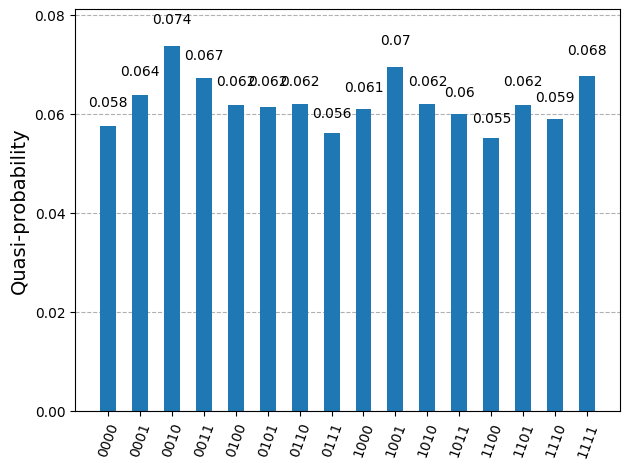

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

qc = qc_4targets_5iter # To test the hardware with different circuits, change this line
qc.measure_all()

pmA = generate_preset_pass_manager(optimization_level=3, backend=A)
isaA = pmA.run(qc)

shots = 4000
counts = Sampler(mode=A).run([isaA], shots=shots).result()[0].data.meas.get_counts()
probs = {state: count / shots for state, count in counts.items()}
plot_histogram(probs)

Multiple target results for the hardware
| Targets | After 1 iter. | After 2 iter. | After 3 iter. | After 4 iter. | After 5. iter |
| ------- | ------------- | ------------- | ------------- | ------------- | ------------- |
| 1 | 0.362 | **0.61** | 0.52 | 0.287 | 0.054 |
| 2 | 0.592 | **0.604** | 0.222 | 0.11 | 0.201 |
| 3 | **0.7** | 0.457 | 0.19 | 0.266 | 0.288 |
| 4 | **0.71** | 0.226 | 0.247 | 0.253 | 0.251 |

Observations:
- all observations made in the Simulator section still apply;
- differences between individual outcome probabilities, particularly for optimal iteration values, are much less pronounced than in the Simulator (for instance, the highest probability of success we have is 0.71, whereas in the Simulator, we had multiple instances where the odds of getting the right answer were >0.9)

# Final tally

| Targets | Expected Value | Simulator | Hardware |
| ------- | -------------- | --------- | -------- |
| 1       | 3 (3.14...)    | 3         | 2        |
| 2       | 2 (2.22...)    | 2         | 2        |
| 3       | 1 (1.81...)    | 1         | 1        |
| 4       | 1 (1.57...)    | 1         | 1        |

Observations:
- hardware noise causes certain values to fluctuate more than one would expect, and leads to certain expected trends to not be strictly applicable (e.g.: for this set of executions, the optimal iteration value for 1 target was 2, whereas the expected value provided by theory is 3)